<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent;"><a href = "https://www.lpp.polytechnique.fr"><img src="https://github.com/ramp-kits/solar_wind/raw/master/logo_LPP_top.png" width="40%"></td>
    <td align="center"; style="background-color:transparent; width: 50%;"><a href = "https://dataia.eu/"><img src="https://github.com/ramp-kits/solar_wind/raw/master/DATAIA-h.png" width="60%"></a></td>
  </tr>
</table> 
</div>


# RAMP on detecting Solar storms

_Joris van den Bossche, Gautier Nguyen, Nicolas Aunai & Balazs Kegl_

In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt

from problem import get_train_data

ModuleNotFoundError: No module named 'pyarrow'

## The data

We start with inspecting the training data:

In [ ]:
data_train, labels_train = get_train_data()

In [40]:
data_train.head()

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
1997-10-01 00:00:00,6.584763,3.753262,2.303108,0.966140,2.602693,-5.179685,2.668414,2.290824,23.045732,24.352797,...,2.757919e+09,2.472087e+09,378.313934,80.613098,-351.598389,-138.521454,6.956387,7.641340,5.487331e-15,0.668473
1997-10-01 00:10:00,6.036456,0.693559,1.810752,-0.904843,2.165570,-1.944006,2.372931,2.119593,23.000492,20.993362,...,3.365612e+09,3.087122e+09,350.421021,69.919327,-331.012146,-110.970787,-21.269474,9.149856,4.783776e-15,0.753848
1997-10-01 00:20:00,5.653682,-4.684786,0.893058,-2.668830,0.768677,1.479302,1.069266,2.876815,20.676191,17.496399,...,1.675611e+09,1.558640e+09,328.324493,92.194435,-306.114899,-117.035202,-13.018987,11.924199,3.719768e-15,0.282667
1997-10-01 00:30:00,5.461768,-4.672382,1.081638,-2.425630,0.765681,1.203713,0.934445,2.851195,20.730188,16.747108,...,1.589037e+09,1.439569e+09,319.436859,94.230705,-298.460938,-110.403969,-20.350492,16.032987,3.525211e-15,0.304713
1997-10-01 00:40:00,6.177846,-5.230110,1.046126,-2.872561,0.635256,1.505010,0.850657,3.317076,20.675701,17.524536,...,1.812308e+09,1.529260e+09,327.545929,89.292595,-307.303070,-111.865845,-12.313167,10.253789,3.694283e-15,0.244203


The data consist of 30 primary input variables: the bulk  velocity and its components $V,V_{x}, V_{y}, V_{z} $, the thermal velocity $V_{th}$, the magnetic field, its components and their RMS : $B, B_{x}, B_{y}, B_{z}, \sigma_{B_x}, \sigma_{B_y}, \sigma_{B_z}$, the density of protons and $\alpha$ particles obtained from both moment and non-linear analysis : $N_{p}, N_{p,nl}$ and $N_{a,nl}$ as well as 15 canals of proton flux between 0.3 and 10 keV. 

The data are resampled to a 10 minute resolution. 

In addition to the 30 input variables, we computed 3 additional features that will also serve as input variables : the plasma parameter $\beta$, defined as the ratio between the thermal and the magnetic pressure, the dynamic pressure $P_{dyn} = N_{p}V^{2}$ and the normalized magnetic fluctuations : $\sigma_{B} = \sqrt{(\sigma_{B_x}^{2}+\sigma_{B_y}^{2}+\sigma_{B_z}^{2}})/B$. 

In [41]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 509834 entries, 1997-10-01 00:00:00 to 2007-12-31 23:50:00
Data columns (total 33 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   B           509834 non-null  float32
 1   Bx          509834 non-null  float32
 2   Bx_rms      509834 non-null  float32
 3   By          509834 non-null  float32
 4   By_rms      509834 non-null  float32
 5   Bz          509834 non-null  float32
 6   Bz_rms      509834 non-null  float32
 7   Na_nl       509834 non-null  float32
 8   Np          509834 non-null  float32
 9   Np_nl       509834 non-null  float32
 10  Range F 0   509834 non-null  float32
 11  Range F 1   509834 non-null  float32
 12  Range F 10  509834 non-null  float32
 13  Range F 11  509834 non-null  float32
 14  Range F 12  509834 non-null  float32
 15  Range F 13  509834 non-null  float32
 16  Range F 14  509834 non-null  float32
 17  Range F 2   509834 non-null  float32
 18  Range F 3 

In [42]:
print(f"Missing data : {data_train.isnull().sum().any()}")

Missing data : False


The target labels consists of an indicator for each time step (O for background solar wind, 1 for solar storm, the event to detect):

In [43]:
labels_train.value_counts()

0    451269
1     58565
Name: label, dtype: int64

The dataset is imbalanced

### An example ICME "solar storm" event

ICMEs signatures as measured by in-situ spacecraft thus come as patterns in time series of the magnetic field, the particle density, bulk velocity, temperature etc. 

Let's visualize a typical event to inspect the patterns.

In [44]:
def plot_event(start, end, data, delta=36):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    subset = data[
        (start - pd.Timedelta(hours=delta)) : (end + pd.Timedelta(hours=delta))
    ]

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15), sharex=True)

    # plot 1
    axes[0].plot(subset.index, subset["B"], color="gray", linewidth=2.5)
    axes[0].plot(subset.index, subset["Bx"])
    axes[0].plot(subset.index, subset["By"])
    axes[0].plot(subset.index, subset["Bz"])
    axes[0].legend(
        ["B", "Bx", "By", "Bz (nT)"], loc="center left", bbox_to_anchor=(1, 0.5)
    )
    axes[0].set_ylabel("Magnetic Field (nT)")

    # plot 2
    axes[1].plot(subset.index, subset["Beta"], color="gray")
    axes[1].set_ylim(-0.05, 1.7)
    axes[1].set_ylabel("Beta")

    # plot 3
    axes[2].plot(subset.index, subset["V"], color="gray")
    axes[2].set_ylabel("V(km/s)")
    # axes[2].set_ylim(250, 500)

    # plot 4
    axes[3].plot(subset.index, subset["Vth"], color="gray")
    axes[3].set_ylabel("$V_{th}$(km/s)")
    # axes[3].set_ylim(5, 60)

    # add vertical lines
    for ax in axes:
        ax.axvline(start, color="k")
        ax.axvline(end, color="k")
        ax.xaxis.grid(True, which="minor")

    return fig, axes

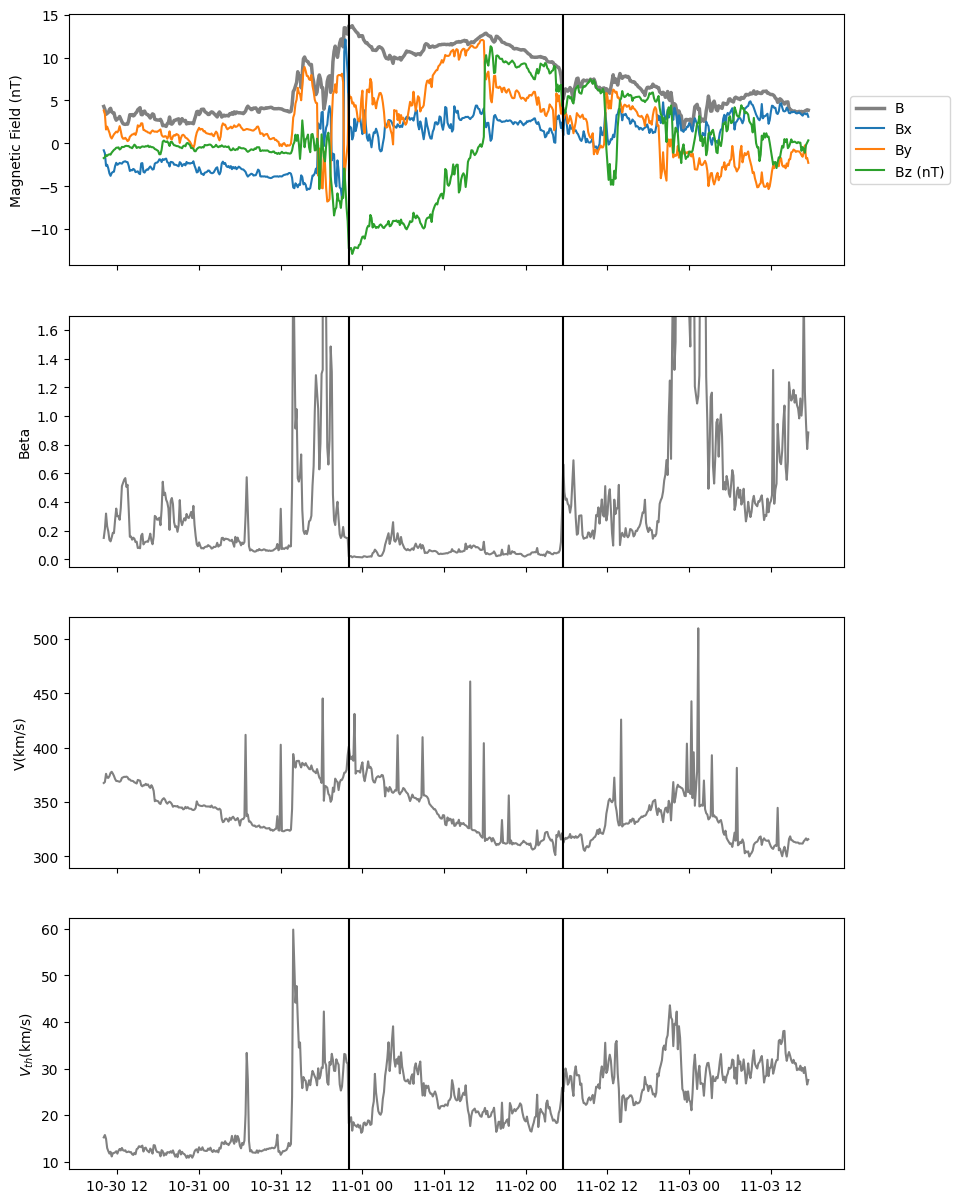

In [45]:
plot_event(
    pd.Timestamp("2001-10-31 22:00:00"), pd.Timestamp("2001-11-02 05:30:00"), data_train
);

Not all events will be "text-book" examples and don't always exhibit all typical characteristics.

Visualizing some more, randomly drawn events:

In [46]:
from problem import turn_prediction_to_event_list

In [47]:
events = turn_prediction_to_event_list(labels_train)

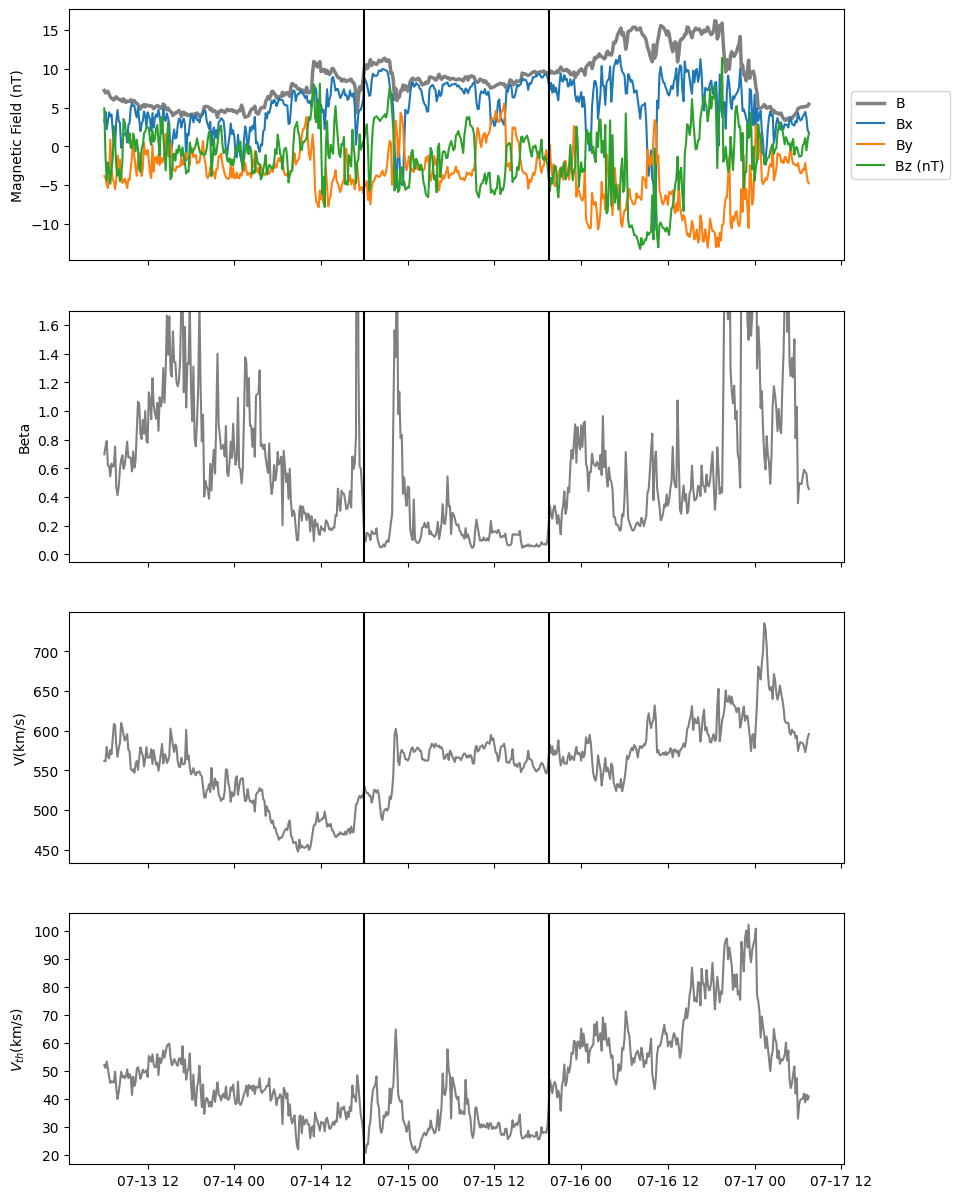

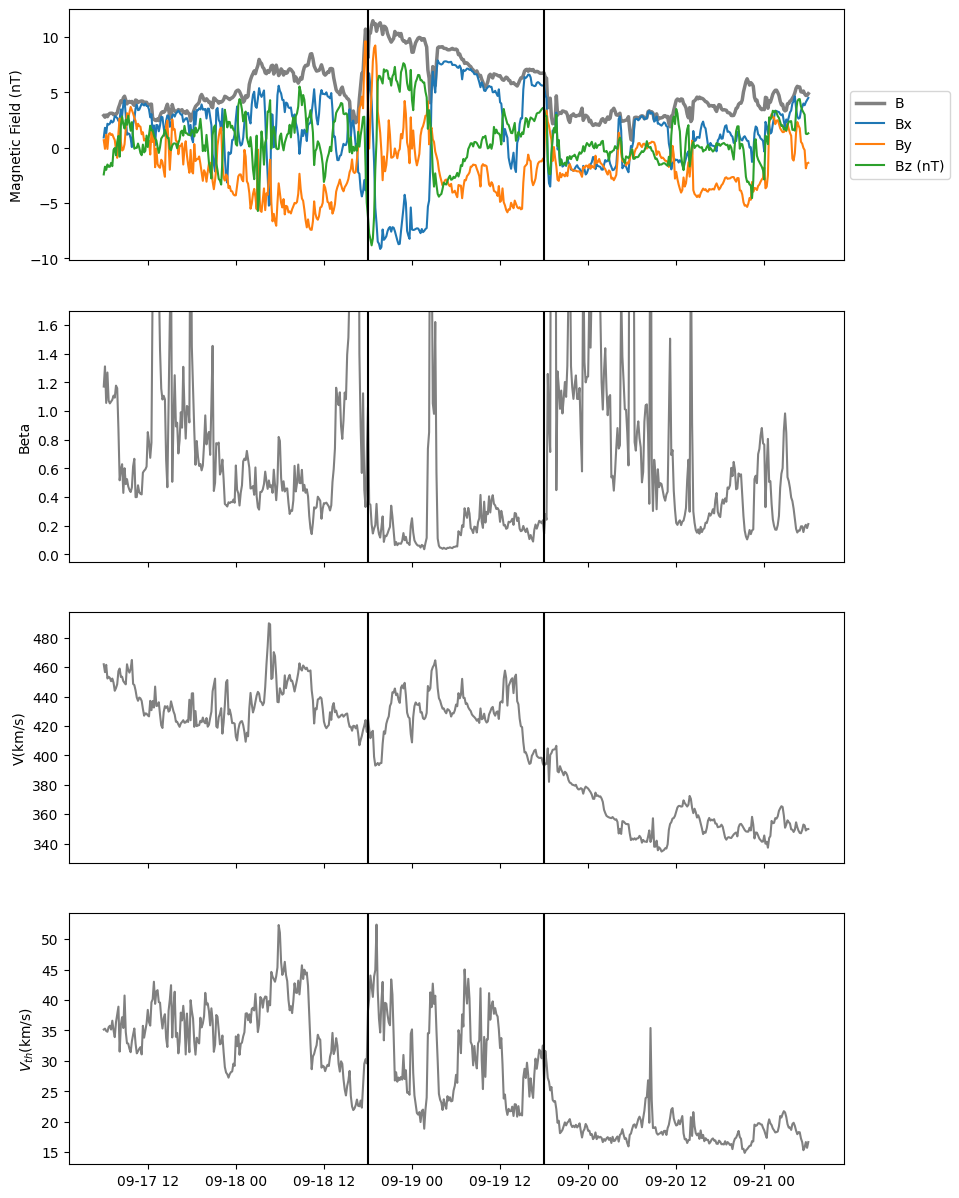

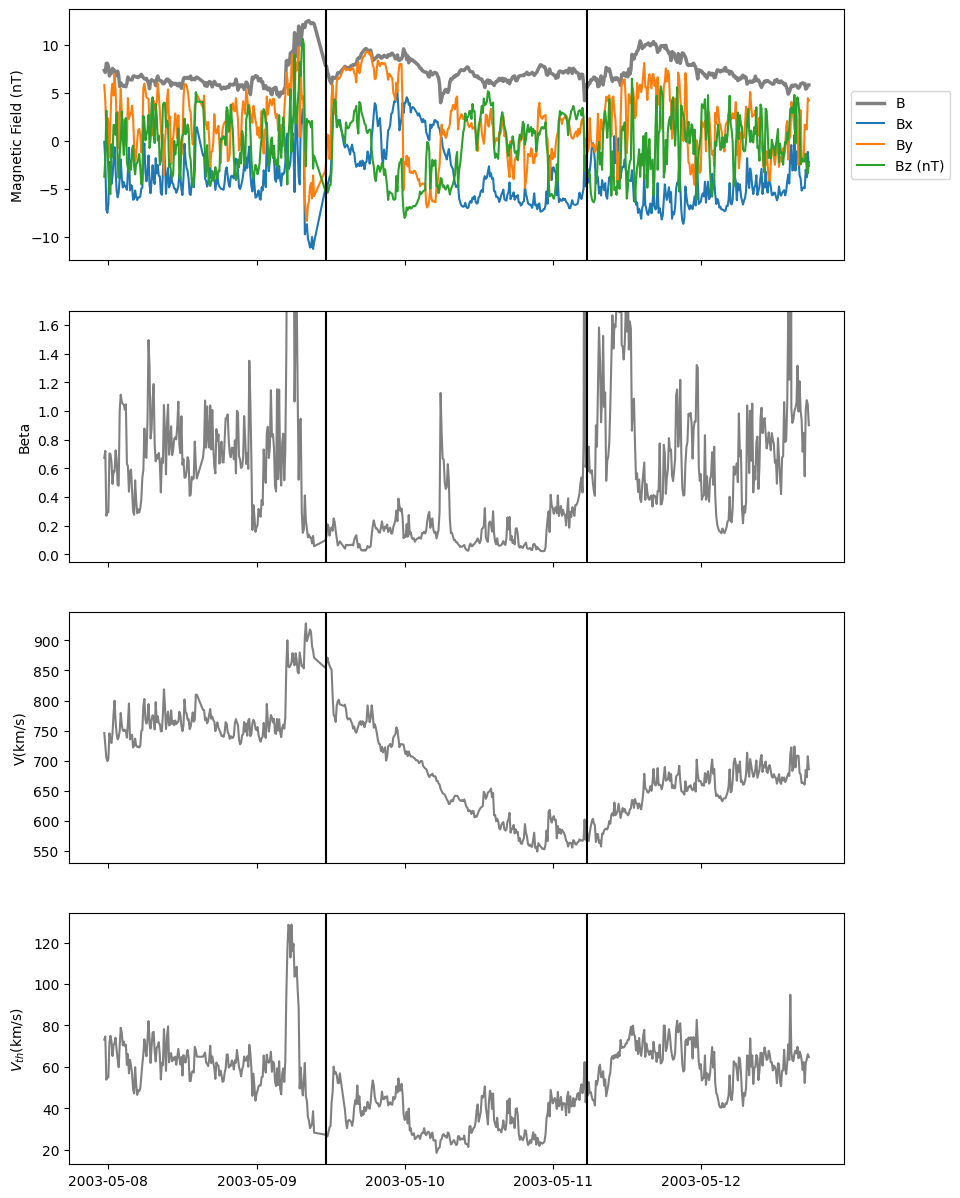

In [48]:
rng = np.random.RandomState(1234)

for i in rng.randint(0, len(events), 3):
    plot_event(events[i].begin, events[i].end, data_train)

### The duration of events

The ICME's can take from several hours to several days. 

In [49]:
duration = [ev.end - ev.begin for ev in events]
duration = pd.Series(duration).dt.total_seconds() / 60 / 60

The average duration in hours:

In [50]:
duration.mean()

23.512135922330096

And a distribution of all events in the training dataset:

Text(0.5, 0, 'Duration of an ICME event (hours)')

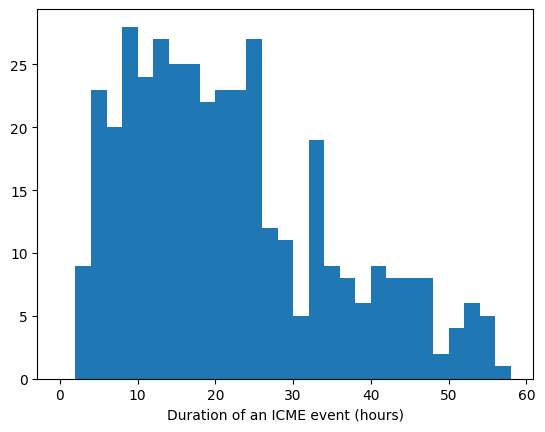

In [51]:
fig, ax = plt.subplots()
ax.hist(duration, bins=np.arange(0, 60, 2))
ax.set_xlabel("Duration of an ICME event (hours)")

### Number of events show a cycle

In [52]:
event_starts = pd.Series([ev.begin for ev in events])

<AxesSubplot: >

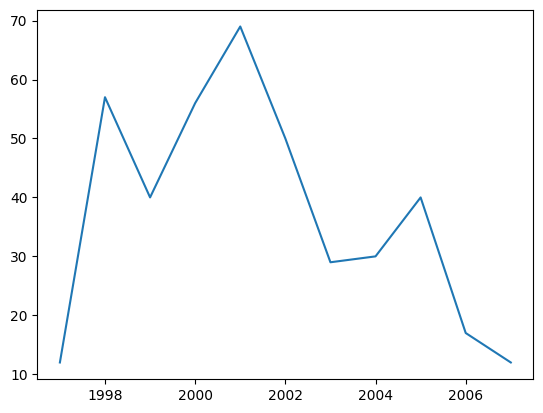

In [53]:
event_starts.groupby(event_starts.dt.year).size().plot()

### Imbalance between solar wind and solar storm

Looking at the raw labels, the background solar wind is more common than the solar storm:

<AxesSubplot: >

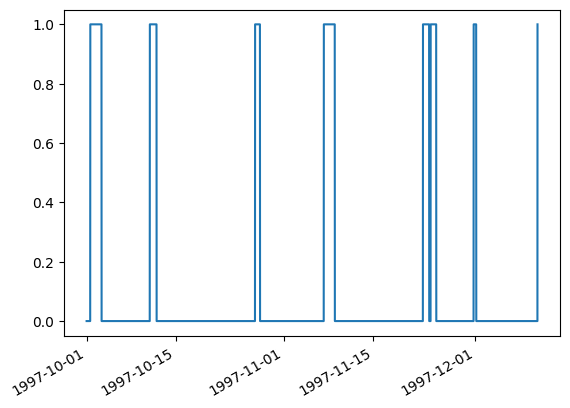

In [54]:
labels_train[:10000].plot()

In [55]:
labels_train.value_counts()

0    451269
1     58565
Name: label, dtype: int64

In [56]:
labels_train.value_counts()[1] / len(labels_train)

0.11487072262736499

### Testing data

In order to evaluate the performance of the submissions, the dataset has then been split in three parts, the period between 1997 and 2007 is the public training data and the period of 2008 to 2011 the public testing data. In addition, the data of the period of 2012 to 2015 is not provided and will be used as the hidden test data.

The testing data can be loaded similarly as follows:

In [57]:
from problem import get_test_data

data_test, labels_test = get_test_data()

In [58]:
data_test.head()

,B,Bx,Bx_rms,By,By_rms,Bz,Bz_rms,Na_nl,Np,Np_nl,...,Range F 8,Range F 9,V,Vth,Vx,Vy,Vz,Beta,Pdyn,RmsBob
2008-01-01 00:00:00,4.191322,-3.683284,0.174691,1.798880,0.273878,-0.362722,0.428125,0.132609,6.028121,4.624486,...,9.860334e+08,1.558658e+09,346.071014,36.012177,-345.823730,2.977509,-6.587379,0.934875,1.208364e-15,0.129070
2008-01-01 00:10:00,4.257490,-2.976951,0.144501,2.953034,0.125648,0.410667,0.274116,0.123604,6.149254,5.863568,...,1.126279e+09,1.762056e+09,348.415741,34.976662,-348.193298,-5.476861,-10.663119,0.872927,1.248913e-15,0.079137
2008-01-01 00:20:00,4.190869,-3.058623,0.286867,2.442341,0.311452,-0.292565,0.326747,0.101965,6.070359,5.217190,...,1.144053e+09,1.718165e+09,348.164673,34.677750,-347.992798,-1.428905,-8.036335,0.879172,1.231391e-15,0.132966
2008-01-01 00:30:00,4.261395,-1.951039,0.148014,3.703976,0.095857,-0.347672,0.228227,0.079186,6.000411,5.828165,...,1.098246e+09,1.878379e+09,356.162506,32.947617,-355.946167,-10.620467,-5.134477,0.764977,1.272731e-15,0.069234
2008-01-01 00:40:00,4.267907,-1.729106,0.101710,3.840123,0.068386,0.392823,0.159227,0.073780,5.841330,5.708538,...,1.202470e+09,1.859657e+09,357.871826,31.242083,-357.522736,-9.289846,-12.252926,0.657990,1.251328e-15,0.047655


## Workflow


ICMEs are the interplanetary counterpart of Coronal Mass Ejections (CMEs), the expulsion of large quantities of plasma and magnetic field that result from magnetic instabilities occurring in the Sun atmosphere (Kilpua et al. (2017) and references therein).  They travel at several hundred or thousands of kilometers per second and, if in their trajectory, can reach Earth in 2-4 days.

ICMEs interact with the planetary environment and may result in intense internal activity such as strong particle acceleration, so-called geomagnetic storms and geomagnetic induced currents. These effects have serious consequences regarding space and ground technologies and understanding them is part of the so-called space weather discipline.
ICMEs signatures as measured by in-situ spacecraft thus come as patterns in time series of the magnetic field, the particle density, bulk velocity, temperature etc. Although well visible by expert eyes, these patterns have quite variable characteristics which makes naive automatization of their detection difficult. To overcome this problem, Lepping et al. (2005) proposed an automatic detection method based on manually set thresholds on a set of physical parameters. However, the method allowed to detect only 60 % of the ICMEs with a high percentage of false positives (60%). Moreover, because of the subjectivity induced by the manually set threshold, the method had difficulties to create a reproducible and constant ICME catalog.

This challenge proposes to design the best algorithm  to detect ICMEs from the most complete ICME catalog containing 657 events. We propose to give to the users a subset of this large dataset in order to test and calibrate their algorithm. We provide in-situ data measurement by the WIND spacecraft between 1997 and 2016, that we sampled to a 10 minutes resolution and for which we computed three additional features that proved to be useful in the visual identification of ICMEs. Using an appropriate metric, we will compare the true solution to the estimation. The goal is to provide an ICME catalog containing less than 10% of false positives while recording as much existing event as possible.

Formally, each instance will consist of a measurement of various physical parameters in the interplanetary medium. The training set will contain data measurement from 1997 to 2010 and the beginning and ending dates of the 438 ICMEs that were measured in this period : tstart and tend.

<img src="./img/workflow.png" width="100%">

### The model to submit

The submission consists of one file: `estimator.py` which defines a `get_estimator` function returning a scikit-learn model from which we will call `fit` and `predict` methods. The prediction should be in the form of a (n_samples, 2) array with the probabilities of the two classes.

---

An example `get_estimator`, adding an additional feature based on a moving window to include some time-aware features, a standard scaler and a classifier doing a Logistic Regression:

In [59]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def compute_rolling_std(X_df, feature, time_window, center=False):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std"])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df


class FeatureExtractor(BaseEstimator):
    def fit(self, X, y):
        return self

    def transform(self, X):
        return compute_rolling_std(X, "Beta", "2h")


def get_estimator():

    feature_extractor = FeatureExtractor()

    classifier = LogisticRegression(max_iter=1000)

    pipe = make_pipeline(feature_extractor, StandardScaler(), classifier)
    return pipe

Using thus model interactively in the notebook to fit on the training data and predict for the testing data:

In [60]:
model = get_estimator()

In [61]:
model.fit(data_train, labels_train)

Pipeline(steps=[('featureextractor', FeatureExtractor()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [62]:
y_pred = model.predict_proba(data_test)

Thre predictions are a 2D array:

In [63]:
y_pred.shape

(205574, 2)

In [64]:
y_pred

array([[0.99209903, 0.00790097],
       [0.9845058 , 0.0154942 ],
       [0.99120201, 0.00879799],
       ...,
       [0.91487279, 0.08512721],
       [0.95712052, 0.04287948],
       [0.96906331, 0.03093669]])

### Evaluation

Evaluating it on the individual points, we use the Logistic Loss (`pw_ll`) and predicion (`pw_prec`) and recall (`pw_rec`) for the positive class (the 1's in the labels, i.e. the storms):

In [35]:
from sklearn.metrics import log_loss, classification_report

In [36]:
log_loss(labels_test, y_pred)

0.16436341764073148

In [37]:
# using argmax here to convert the probabilities to binary 0/1
print(classification_report(labels_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    191755
           1       0.87      0.17      0.28     13819

    accuracy                           0.94    205574
   macro avg       0.91      0.58      0.62    205574
weighted avg       0.94      0.94      0.92    205574



Next to this "point-wise" evaluation as shown above, we also evaluate on the ICME event level. 

Currently, the **predicted events** are determined from the `y_pred` probabilities in a simple way: 

* Consecutive periods where the probability is above 0.5 is considered as 1 event. 
* Events that are less than 1 hour apart from each other are merged, and events shorter than 2.5 hours are removed

For those predicted events, we then calculate the precison (`ev_prec`) and recall (`ev_rec`).

Wrapping the predicted probabilities in a pandas Series with the original datetime-index:

In [38]:
s_y_pred = pd.Series(y_pred[:, 1], index=labels_test.index)

Taking a small example part of the test data and predictions:

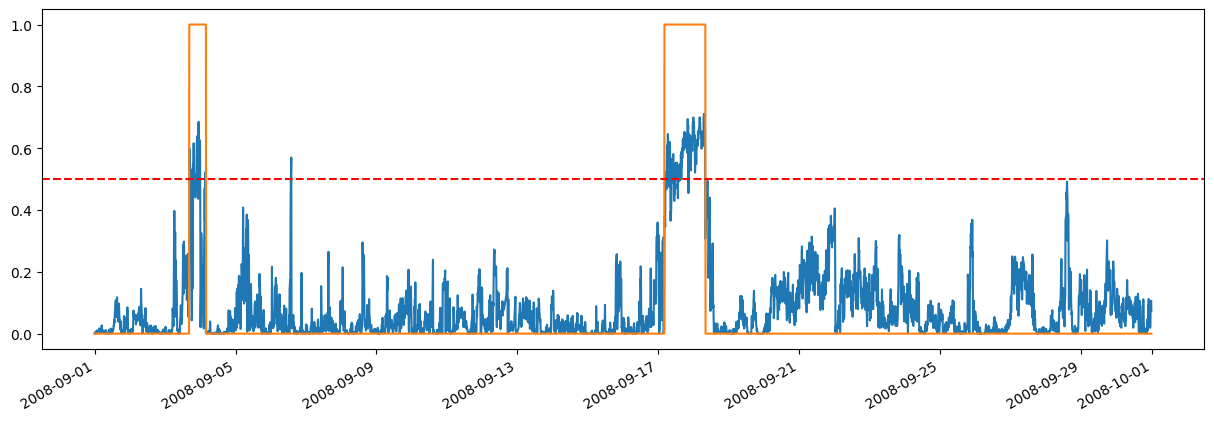

In [39]:
start, stop = "2008-09-01", "2008-09-30"
ax = s_y_pred[start:stop].plot(figsize=(15, 5))
labels_test[start:stop].plot(ax=ax)
ax.axhline(0.5, color="r", linestyle="--")

Zooming into the first event, and highlighting which area has been determined as "predicted event":

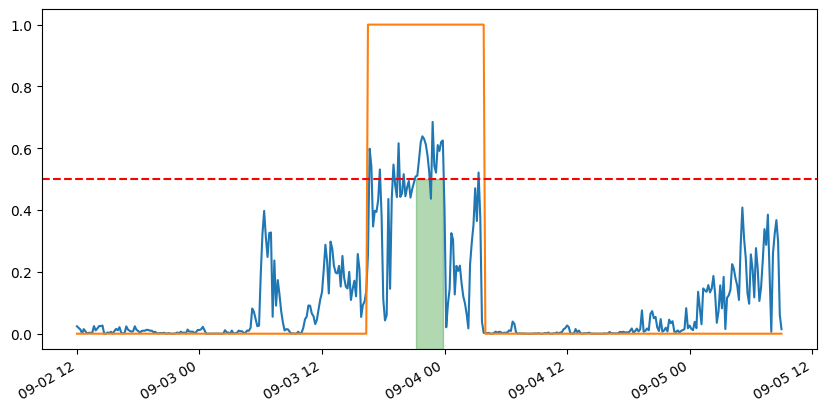

In [40]:
start, stop = "2008-09-02 12:00", "2008-09-05 09:00"
ax = s_y_pred[start:stop].plot(figsize=(10, 5))
labels_test[start:stop].plot(ax=ax)
ax.axhline(0.5, color="r", linestyle="--")

events = turn_prediction_to_event_list(s_y_pred[start:stop])
for evt in events:
    ax.axvspan(evt.begin, evt.end, ymax=0.5, color="g", alpha=0.3)

In [41]:
events

[Event(2008-09-03 21:10:00 ---> 2008-09-03 23:50:00)]

This shows that you might want to post-process the raw probabilities, to enhance this determination of the events. For example, using a simple smoothing:

In [42]:
s_y_pred_smoothed = s_y_pred.rolling(12, min_periods=0, center=True).quantile(0.90)

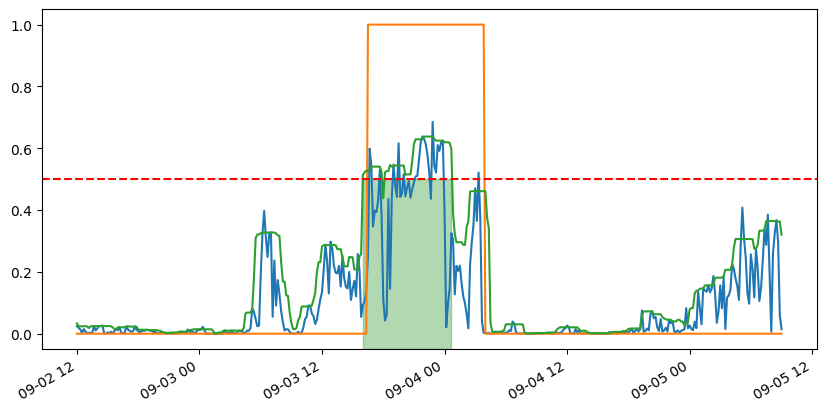

In [43]:
start, stop = "2008-09-02 12:00", "2008-09-05 09:00"
ax = s_y_pred[start:stop].plot(figsize=(10, 5))
labels_test[start:stop].plot(ax=ax)
s_y_pred_smoothed[start:stop].plot(ax=ax)

ax.axhline(0.5, color="r", linestyle="--")

events = turn_prediction_to_event_list(s_y_pred_smoothed[start:stop])
for evt in events:
    ax.axvspan(evt.begin, evt.end, ymax=0.5, color="g", alpha=0.3)

Based on those events, we calculate precision and recall:

In [44]:
from problem import turn_prediction_to_event_list, overlap_with_list, find


def precision(y_true, y_pred):
    event_true = turn_prediction_to_event_list(y_true)
    event_pred = turn_prediction_to_event_list(y_pred)
    FP = [
        x
        for x in event_pred
        if max(overlap_with_list(x, event_true, percent=True)) < 0.5
    ]
    if len(event_pred):
        score = 1 - len(FP) / len(event_pred)
    else:
        # no predictions -> precision not defined, but setting to 0
        score = 0
    return score


def recall(y_true, y_pred):
    event_true = turn_prediction_to_event_list(y_true)
    event_pred = turn_prediction_to_event_list(y_pred)
    if not event_pred:
        return 0.0
    FN = 0
    for event in event_true:
        corresponding = find(event, event_pred, 0.5, "best")
        if corresponding is None:
            FN += 1
    score = 1 - FN / len(event_true)
    return score

In [45]:
precision(labels_test, s_y_pred)

0.19565217391304346

In [46]:
recall(labels_test, s_y_pred)

0.08411214953271029

### Evaluation with Cross-Validation

The metrics explained above are actually calcualted using a cross-validation approach (5-fold cross-validation): 

In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), get_estimator())
    cv = get_cv(X, y)
    results = cross_validate(
        pipe,
        X,
        y,
        scoring=["neg_log_loss"],
        cv=cv,
        verbose=1,
        return_train_score=True,
        n_jobs=1,
    )

    return results

In [66]:
results = evaluation(data_train, labels_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   55.7s finished


In [67]:
print(
    "Training score Log Loss: {:.3f} +- {:.3f}".format(
        -np.mean(results["train_neg_log_loss"]), np.std(results["train_neg_log_loss"])
    )
)
print(
    "Testing score Log Loss: {:.3f} +- {:.3f} \n".format(
        -np.mean(results["test_neg_log_loss"]), np.std(results["test_neg_log_loss"])
    )
)

Training score Log Loss: 0.229 +- 0.030
Testing score Log Loss: 0.244 +- 0.045 



## Custom model

In [113]:
import statsmodels.tsa.seasonal.seasonal_decompose

ModuleNotFoundError: No module named 'statsmodels'

In [68]:
data_train.B.autocorr()

0.8810519005831804

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

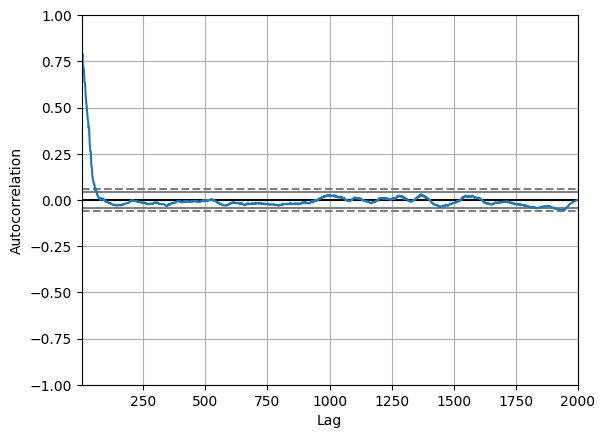

In [110]:
pd.plotting.autocorrelation_plot(data_train.iloc[:2000,2])

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


def compute_rolling_std(X_df, feature, time_window, center=False):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std"])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df


def compute_diff(X_df, diff_step):

    return X_df


class FeatureExtractor(BaseEstimator):
    def fit(self, X, y):
        return self

    def transform(self, X):
        return compute_rolling_std(X, "Beta", "2h")


def get_estimator():

    feature_extractor = FeatureExtractor()

    classifier = LogisticRegression(max_iter=1000)

    pipe = make_pipeline(feature_extractor, StandardScaler(), classifier)
    return pipe

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), get_estimator())
    cv = get_cv(X, y)
    results = cross_validate(
        pipe,
        X,
        y,
        scoring=["neg_log_loss"],
        cv=cv,
        verbose=1,
        return_train_score=True,
        n_jobs=1,
    )

    return results

In [ ]:
results = evaluation(data_train, labels_train)

In [ ]:
print(
    "Training score Log Loss: {:.3f} +- {:.3f}".format(
        -np.mean(results["train_neg_log_loss"]), np.std(results["train_neg_log_loss"])
    )
)
print(
    "Testing score Log Loss: {:.3f} +- {:.3f} \n".format(
        -np.mean(results["test_neg_log_loss"]), np.std(results["test_neg_log_loss"])
    )
)

## Submitting to the online challenge: [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit them to [ramp.studio](http://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then sign up to the event [solar_wind](http://www.ramp.studio/events/solar_wind). Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/solar_wind/sandbox) and copy-paste. You can also create a new starting-kit in the `submissions` folder containing `estimator.py` and upload this file directly. You can check the starting-kit ([`estimator.py`](/edit/submissions/starting_kit/estimator.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/solar_wind_datacamp2022/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/solar_wind_datacamp2022/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/solar_wind_datacamp2022/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores 

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/solar_wind_datacamp2022/leaderboard)) is the mixed log-loss/f1 score (`mixed`). When the score is good enough, you can submit it at the RAMP.

In [ ]:
!ramp-test --submission starting_kit  # --quick-test to select only a small part of the data

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Questions

Questions related to the starting kit should be asked on the [issue tracker](https://github.com/ramp-kits/solar_wind/issues). The RAMP site administrators can be pinged at the RAMP slack team.